## Проект 8. Прогнозирование стоимости автомобиля с пробегом
### Грачева Татьяна, Еременко Виктория¶

### Дополнительный ноутбук: использование трансформеров для анализа текста

В этом ноутбуке для анализа текста применяется трансформер ( в составе multi-input сети).

Были опробованы 3 модели:
* https://huggingface.co/cointegrated/LaBSE-en-ru
* https://huggingface.co/sberbank-ai/sbert_large_mt_nlu_ru
* https://huggingface.co/promobot/labse-ru

Последние две давали сопоставимый результат (mape ~ 16.5 при использовании в качестве одиночной модели для предсказания цены, темп обучения был 5e-5). В итоге была выбрана сеть "promobot/labse-ru", тк в ней гораздо меньше параметров, чем в модели от СБ, и работала она существенно быстрее.

Текст был очищен и лемматизирован перед подачей в модель, тк это давало лучшие результаты.

Финальная модель тренировалась с более высоким темпом обучения (для экономии времени и вычислительных ресурсов). 


In [1]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
!pip install transformers

In [3]:
!pip install pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 47.5 MB/s eta 0:00:00


In [4]:
# импорт библиотек

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#from pandas_profiling import ProfileReport
import os
import sys
import zipfile
import PIL
from PIL import ImageOps, ImageFilter
import re
import ast
from datetime import time, date, datetime
import random

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-paper')

from optuna import *

import pymorphy2

from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import SelectKBest, chi2, f_classif, f_regression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.impute import KNNImputer

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor


from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import VotingRegressor
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor, Pool, cv

#image augmentation
#import albumentations as A
#from ImageDataAugmentor.image_data_augmentor import *

# keras
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import MeanAbsolutePercentageError

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, DataCollatorWithPadding

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')


pd.set_option('display.max_columns', 550) # больше колонок

os.environ['PYTHONHASHSEED']=str(42)

In [5]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
Numpy        : 1.21.6
Tensorflow   : 2.6.4


In [6]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [7]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Setup

In [8]:
VERSION    = 1
DIR_TRAIN  = '../input/sf-dst-car-price-prediction-part2/' # подключили к ноутбуку свой внешний датасет
VAL_SIZE   = 0.15   
N_FOLDS    = 5

# CATBOOST
ITERATIONS = 2000
LR         = 0.01

# Data

Каггл

In [9]:
!ls ../input/

sf-dst-car-price-prediction-part2


In [10]:
train = pd.read_csv(DIR_TRAIN+'train.csv') # подготовленный датасет для обучения модели
test = pd.read_csv(DIR_TRAIN+'test.csv')
sample_submission = pd.read_csv(DIR_TRAIN+'sample_submission.csv')

Локально

In [11]:
#train = pd.read_csv('train.csv')
#test = pd.read_csv('test.csv')
#sample_submission = pd.read_csv('sample_submission.csv')

In [12]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


## Data Preprocessing

Функции предобработки данных

In [13]:
# Функция расчета ошибки
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

# Функция расчета ошибки для логарифмированной целевой переменнной
def mape_log(y_true, y_pred):
    return np.mean(np.abs((np.exp(y_pred)-np.exp(y_true))/np.exp(y_true)))

# обработка данных
def get_correct_engineDisplacement(x):
    ''' Функция приводит объем двигателя к числовому формату'''
    
    if x == 'undefined LTR':  # у электрокаров объем равен 0 
        return 0
    
    x = float(x.split(' LTR')[0])
    
    return x

def num_of_months(row):
    ''' Функция считает время владения машиной в месяцах'''
    
    if pd.notnull(row):
        list_ownership = row.split()
        if len(list_ownership) == 2:
            if list_ownership[1] in ['год', 'года', 'лет']:
                return int(list_ownership[0])*12
            return int(list_ownership[0])
        return int(list_ownership[0])*12 + int(list_ownership[3])


def fill_na_ownership(row):
    ''' Функция для заполнения пропущенных значений (время владения машиной)'''
    
    row['Владение'] = ownership_dict.get(row['Владельцы'])
    
    return row


# функции обработки текста

def remove_punctuations(data):
    ''' Функция удаляет знаки препинания'''
    
    punct_tag=re.compile(r'[^\w\s]')
    data=punct_tag.sub(r' ',data)
    return data


def remove_emoji(data):
    ''' Функция удаляет эмоджи'''    
    
    emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    data=emoji_clean.sub(r'',data)
    return data


def remove_numbers(data):
    ''' Функция удаляет цифры'''
    
    num_tag=re.compile(r'[\d]')
    data=num_tag.sub(r'',data)
    return data

def remove_latin_literals(data):
    ''' Функция удаляет латиницу'''
    
    lit_tag=re.compile(r'[abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ]')
    data=lit_tag.sub(r'',data)
    return data

# округление предсказаний
def round_to(x, a):
    ''' Функция округления до заданной величины'''
    
    return round(x / a) * a

def round_ceil(x, a):
    ''' Функция округления до заданной величины в большую сторону'''
    
    return np.ceil(x / a) * a
    

## Анализ объединенного датасета

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              8353 non-null   object 
 1   brand                 8353 non-null   object 
 2   color                 8353 non-null   object 
 3   description           8353 non-null   object 
 4   engineDisplacement    8353 non-null   object 
 5   enginePower           8353 non-null   object 
 6   fuelType              8353 non-null   object 
 7   mileage               8353 non-null   int64  
 8   modelDate             8353 non-null   int64  
 9   model_info            8353 non-null   object 
 10  name                  8353 non-null   object 
 11  numberOfDoors         8353 non-null   int64  
 12  productionDate        8353 non-null   int64  
 13  sell_id               8353 non-null   int64  
 14  vehicleConfiguration  8353 non-null   object 
 15  vehicleTransmission  

In [15]:
data.head()

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,sample,price
0,универсал 5 дв.,MERCEDES,чёрный,Всем привет!\n\nПродам эксклюзивный проект 124...,3.0 LTR,220 N12,бензин,350000,1984,W124,300 3.0 AT (220 л.с.),5,1991,1099427284,WAGON_5_DOORS AUTOMATIC 3.0,автоматическая,3 или более,6 лет и 3 месяца,Оригинал,задний,Левый,0,0.0
1,купе,BMW,белый,Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...,3.0 LTR,313 N12,дизель,15000,2011,6ER,640d xDrive 3.0d AT (313 л.с.) 4WD,2,2013,1096405886,COUPE AUTOMATIC 3.0,автоматическая,1 владелец,6 лет и 6 месяцев,Оригинал,полный,Левый,0,0.0
2,купе,BMW,пурпурный,"Машина тут продаётся не в первый раз, НО! Толь...",2.5 LTR,218 N12,бензин,166600,2005,3ER,325xi 2.5 AT (218 л.с.) 4WD,2,2008,1100195294,COUPE AUTOMATIC 2.5,автоматическая,3 или более,NaN,Оригинал,полный,Левый,0,0.0
3,седан,BMW,белый,"Автомобиль в отличном состоянии, весь в родной...",2.0 LTR,136 N12,бензин,147000,2005,3ER,318i 2.0 AT (136 л.с.),4,2007,1099827282,SEDAN AUTOMATIC 2.0,автоматическая,2 владельца,NaN,Оригинал,задний,Левый,0,0.0
4,седан,BMW,чёрный,Немка! с бесключивым доступом и камерой заднег...,2.0 LTR,190 N12,дизель,24000,2016,5ER,520d xDrive 2.0d AT (190 л.с.) 4WD,4,2019,1100076198,SEDAN AUTOMATIC 2.0,автоматическая,1 владелец,NaN,Оригинал,полный,Левый,0,0.0


In [16]:
# В этой колонке дублируется информация из других колонок, так что удаляем
data.drop('vehicleConfiguration', axis = 1, inplace=True)

In [17]:
# Быстрый EDA 
#profile = ProfileReport(data, title='Dataset Pandas Profiling Report', explorative = True)
#profile

## Посмотрим на переменные нашего датасета


#### bodyType - тип кузова
17 разных значения из-за лишней информации в признаке (кол-во дверей). Пропусков нет. 

In [18]:
# В признаке "тип кузова" уберем лишнюю информацию
data.bodyType = data.bodyType.apply(lambda x: x.split(' ')[0])

data.bodyType.nunique()

13

#### engineDisplacement - объем двигателя в литрах

In [19]:
# значение undefined только у электрокаров => у них объем двигателя равен нулю
data[data.engineDisplacement == 'undefined LTR'].fuelType.value_counts()

электро    6
Name: fuelType, dtype: int64

In [20]:
data.engineDisplacement = data.engineDisplacement.apply(get_correct_engineDisplacement)

#### enginePower - мощность двигателя

In [21]:
# приведем признак в тесте в типу данных int64 и уберем ' N12'
data.enginePower = data.enginePower.apply(lambda x: int(x.split(' N12')[0]))

#### Владельцы
В датасете представлены только подержаные машины - от одного и более предыдущих владельцев

In [22]:
# единственный пропуск заполним самым часто встречающимся значением
data['Владельцы'].fillna(data['Владельцы'].value_counts().index[0], inplace=True)
# оставим в этой колонке только число
data['Владельцы'] = data['Владельцы'].apply(lambda x: int(x.split()[0]))

#### Владение - количество лет и месяцев владения машиной у последнего владельца

In [23]:
#Переведем признак в числовой формат - количество месяцев
data['Владение'] = data['Владение'].apply(num_of_months)
#По-прежнему много пропусков
data['Владение'].isna().sum()

5418

In [24]:
# Заполним отсутствующие значения медианой (группируем по количеству владельцев) 
ownership = data[data.Владение != 'NaN'].groupby('Владельцы').Владение.median()
ownership_dict = ownership.to_dict()
data[data.Владение.isna()]= data[data.Владение.isna()].apply(fill_na_ownership, axis=1)

In [25]:
# достанем признак 'xDrive' из колонки name
data['xDrive'] = data['name'].apply(lambda x: 1 if 'xDrive' in x else 0)
# в признаке name оставляем только комплектацию автомобиля
data['name'] = data['name'].str.split().apply(lambda x: x[0])

In [26]:
# датасет был собран в 2020 году, так что отсчет ведем с этого момента
data['car_age'] = 2020 - data.productionDate
# колонку удалим
data.drop('productionDate', axis = 1, inplace=True)

### Анализ категориальных переменных

In [27]:
bin_cols = ['ПТС', 'Руль','xDrive']
cat_cols = ['bodyType', 'brand','color','fuelType', 'model_info', 'name','numberOfDoors', 'vehicleTransmission', 'Владельцы', 'Привод']
num_cols = ['modelDate','engineDisplacement', 'enginePower','mileage', 'car_age', 'Владение']

### Дополнительная обработка категориальных переменных

In [28]:
# Перекодируем бинарные переменные с текстовыми значениями
le = LabelEncoder()
for column in bin_cols:
    data[column] = le.fit_transform(data[column])
    print(dict(enumerate(le.classes_)))

    # Создадим фиктивные переменные на основе категориальных колонок
ohe = OneHotEncoder(sparse = False, dtype='uint8')
cat_cols_encoded = ohe.fit_transform(data[cat_cols].values)
cat_cols_encoded_features = ohe.get_feature_names(cat_cols)
data[cat_cols_encoded_features] = pd.DataFrame(cat_cols_encoded, columns=cat_cols_encoded_features)


dummy_cols= list(cat_cols_encoded_features) + bin_cols

{0: 'Дубликат', 1: 'Оригинал'}
{0: 'Левый', 1: 'Правый'}
{0: 0, 1: 1}


### Числовые переменные

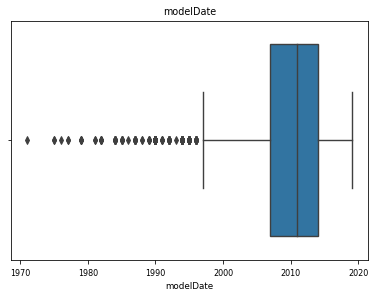

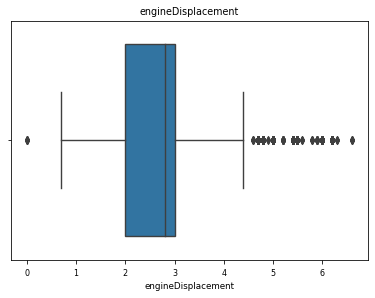

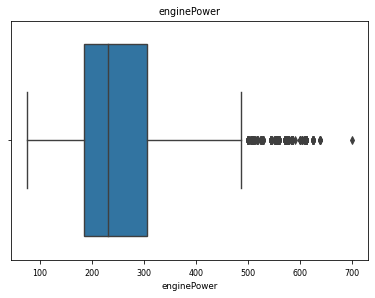

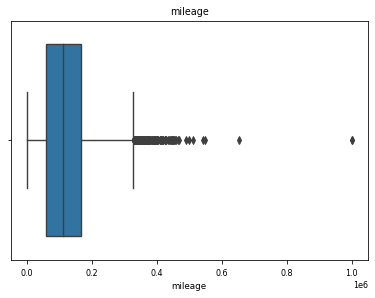

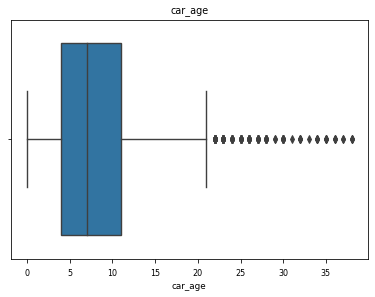

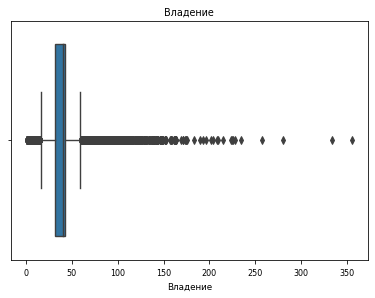

In [29]:
for col in num_cols:
    plt.figure()
    sns.boxplot(data[col])
    plt.title(col)
    plt.show()


Практически во всех числовых переменных есть выбросы, распределения имеют выраженные правые "хвосты".

## Генерация признаков

In [30]:
# Добавим новый признак - длина описания в символах (мб лучше сделать длину в словах?)
data['description_len'] = data['description'].apply(lambda x: len(x))
num_cols.append('description_len')

<AxesSubplot:xlabel='description_len'>

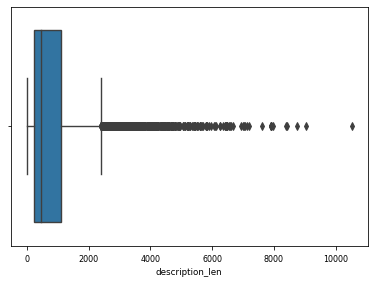

In [31]:
sns.boxplot(data['description_len'])

In [32]:
# признак - километраж за год. 
# Прибавляем 1 к возрасту машины, чтобы километраж был посчитан для машин, которые были произведены в год сбора данных
data['miles_per_year'] = data['mileage'] // (data['car_age'] + 1)
data['miles_per_year'].astype(int)
num_cols.append('miles_per_year')

<AxesSubplot:xlabel='miles_per_year'>

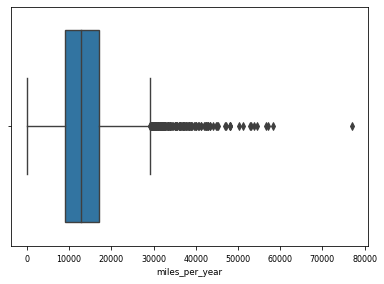

In [33]:
sns.boxplot(data['miles_per_year'])

In [34]:
# введем новый признак "tax" (расчет годового налога):
data['tax'] = data.enginePower.apply(lambda x: x*12 if x <= 100
                                     else x*25 if x > 100 and x <= 125
                                     else x*35 if x > 125 and x <= 150
                                     else x*45 if x > 150 and x <= 175
                                     else x*55 if x > 175 and x <= 200
                                     else x*65 if x > 200 and x <= 225
                                     else x*75 if x > 225 and x <= 250
                                     else x*150)
num_cols.append('tax')

<AxesSubplot:xlabel='tax'>

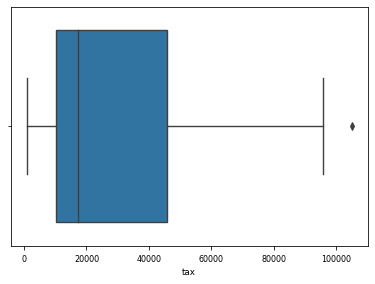

In [35]:
sns.boxplot(data['tax'])

## Отбор признаков

In [36]:
target = 'price'
train_index = data[data['sample'] == 1].index
test_index = data[data['sample'] == 0].index

### Корреляционный анализ

(10.5, -0.5)

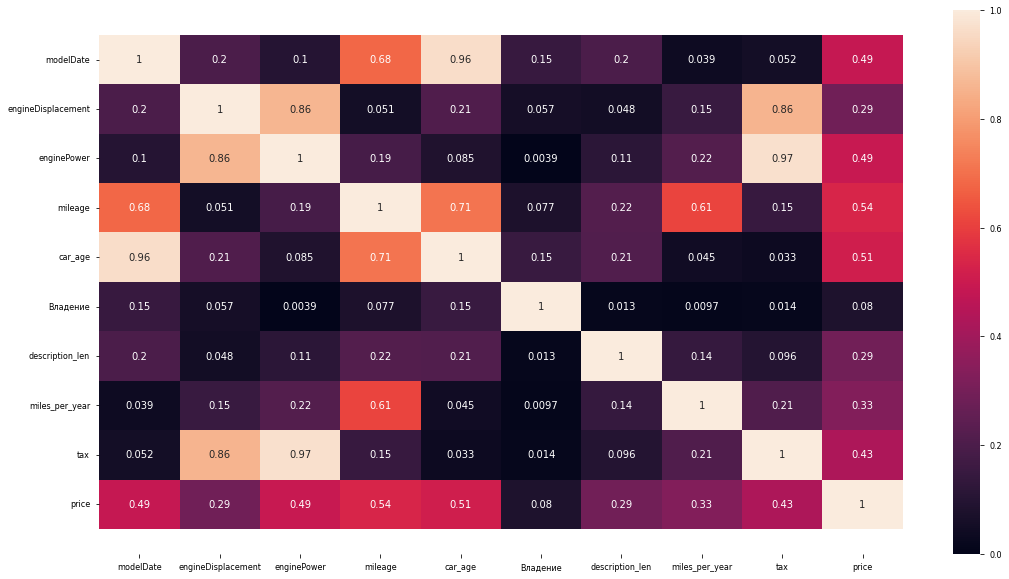

In [37]:
plt.figure(figsize=(18, 10))
ax = sns.heatmap(data.loc[train_index][num_cols+[target]].corr().abs(), vmin=0, vmax=1, annot = True)
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5)


In [38]:
# числовые колонки логарифмируем,чтобы избавиться от правых хвостов распределений
for col in num_cols:
    data[col] = np.log(data[col] + 1)

In [39]:
# логарифмируем цену
data.price = np.log(data.price)

### Подготовка данных для машинного обучения

In [40]:
train_proc = data.loc[train_index]
test_proc = data.loc[test_index]

In [41]:
train_proc.shape, test_proc.shape

((6682, 434), (1671, 434))

In [42]:
X = train_proc[dummy_cols+ num_cols]
X_sub = test_proc[dummy_cols+num_cols]

y = train_proc['price'].values

In [43]:
# стандартизация числовых признаков

scaler = RobustScaler()
X[num_cols]  = scaler.fit_transform(X[num_cols])
X_sub[num_cols]  = scaler.transform(X_sub[num_cols])

## Модели машинного обучения

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

In [45]:
# обратили внимание, что нейросеть лучше дает результат, если цена не логарифмирована.
# соответственно, вернем цену к обычному формату

## NLP сеть

Попробуем извлечь дополнительную информацию из колонки с описанием автомобиля со стороны продавца.

In [46]:
data['description_len_words'] = data['description'].apply(lambda x: len(x.split(' ')))

<AxesSubplot:xlabel='description_len_words'>

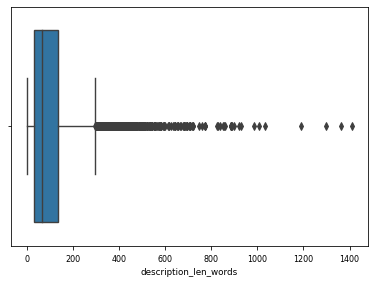

In [47]:
sns.boxplot(data['description_len_words'])

Мы видим, что 75% отзывов укладываются примерно в 300 слов

In [48]:
for i in range(5):
    print(f'Описание {i}\n')
    print(data['description'][i])

Описание 0

Всем привет!

Продам эксклюзивный проект 124 универсал 300TE-24 SportLine

Модель 124.091 300 TE-24
Двигатель 104.980
Трансмиссия 722.359
Цвет кузова 040 (черный)
Отделка салона 271 (Кожа черная / "антрацит")

Опции:
211 Автоматическая блокировка дифференциала (ASD)
240 Индикатор внешней температуры
244 Спортивные сиденья спереди
281 Спортивное рулевое колесо с отделкой из кожи (диаметр 390 мм) и кожаный рычаг КПП
291 Подушка безопасности для водителя и переднего пассажира
300 Дополнительный бардачок в вещевом отсеке спереди
412 Люк с электроприводом и устройством подъёма
420 Автоматическая коробка передач, напольное исполнение
440 Темпомат (круиз-контроль)
538 Автоматическая антенна
541 Двойные занавески для багажного пространства и пасажирского отсека (сетка/шторка)
570 Складной подлокотник спереди
586 Кондиционер Behr и электрические стеклоподъемники передних и задних дверей
598 Атермальные боковые и заднее стекла, заднее стекло с подогревом (ESG)
650 Спортивная подвеска

Что видим здесь:
* большие буквы сохраняются - нужно привести все к нижнему регистру
* поскольку модель русскоязычная, текст на латинице не распознает - нужно по возможности убрать англоязычный текст
* в качестве токенов выделяются запятые, точки, тире, восклицательные знаки - скорее всего, они не несут полезной информации

In [49]:
data['description'] = data['description'].apply(lambda x: x.lower())

In [50]:
# split данных
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

### Очистка и лемматизация

In [51]:
data['description']=data['description'].apply(lambda x: remove_punctuations(x))
data['description']=data['description'].apply(lambda x: remove_emoji(x))
data['description']=data['description'].apply(lambda x: remove_numbers(x))
data['description']=data['description'].apply(lambda x: remove_latin_literals(x))

In [52]:
# удаляем ненужные (неинформативные) слова
stop = stopwords.words('russian')
add_stop = ['км','мм', 'рублей'] + list('абвгдеёжзийклмнопрстуфхцчшщъыьэюяАБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ')
new_stop = stop + add_stop
print(new_stop)

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [53]:
data['description']=data['description'].apply(lambda x: ' '.join([word for word in x.split() if word not in (new_stop)]))
data['description'].head()

0    всем привет продам эксклюзивный проект универс...
1    продаю любимейшую тачилу обвес тюнинг езжу дол...
2    машина продаётся первый перебран двигатель зам...
3    автомобиль отличном состоянии весь родной крас...
4    немка бесключивым доступом камерой заднего вид...
Name: description, dtype: object

In [54]:
%%time

morph = pymorphy2.MorphAnalyzer()


def filter_str(str):
    split_str = str.split()
    filtered_str = ' '.join(
        (map(lambda s: morph.parse(s)[0].normal_form, split_str)))
    return filtered_str


data['description'] = data['description'].apply(filter_str)
data['description']

CPU times: user 2min 33s, sys: 184 ms, total: 2min 33s
Wall time: 2min 34s


0       весь привет продать эксклюзивный проект универ...
1       продавать любимый тачил обвес тюнинг ездить до...
2       машина продаваться первый перебрать двигатель ...
3       автомобиль отличный состояние весь родный крас...
4       немка бесключивый доступ камера задний вид авт...
                              ...                        
8348    продаваться любимый автомобиль год эксплуатаци...
8349    купить официальный дилер третий владелец владе...
8350    торг место работать сборка немецкий резина лет...
8351    автомобиль отличный состояние авто семья обслу...
8352    удлинённый заводский база вообще правильно зав...
Name: description, Length: 8353, dtype: object

In [55]:
for i in range(3):
    print(f'Описание {i}\n')
    print(data['description'][i])

Описание 0

весь привет продать эксклюзивный проект универсал модель двигатель трансмиссия цвет кузов чёрный отделка салон кожа чёрный антрацит опция автоматический блокировка дифференциал индикатор внешний температура спортивный сидение спереди спортивный рулевой колесо отделка кожа диаметр кожаный рычаг кпп подушка безопасность водитель передний пассажир дополнительный бардачок вещевой отсек спереди люк электропривод устройство подъём автоматический коробка передача напольный исполнение темпомат круиз контроль автоматический антенна двойной занавеска багажный пространство пасажирский отсек сетка шторка складный подлокотник спереди кондиционер электрический стеклоподъёмник передний задний дверь атермальный боковой задний стекло задний стекло подогрев спортивный подвеска акб увеличить мощность установленный сзади динамика электрообогрев передний кресло исполнение код дополнительно установленный опция внутренний салонный зеркало автоматический изменение затемнение противобликовый исключ

### Tokenizer

In [56]:
max_length_test = 256

bert_layer = TFAutoModelForSequenceClassification.from_pretrained("promobot/labse-ru", num_labels=1)
tokenizer = AutoTokenizer.from_pretrained("promobot/labse-ru")

Downloading:   0%|          | 0.00/653 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/408M [00:00<?, ?B/s]

2022-06-30 07:46:31.711291: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-30 07:46:31.712717: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-30 07:46:31.713571: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-30 07:46:31.714658: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Downloading:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/328k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/744k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [57]:
tokenizer.is_fast

True

In [58]:
# можно натренировать токенизатор на своем корпусе текстов
batch_size = 500

def batch_iterator():
    for i in range(0, len(data.description), batch_size):
        yield data.description[i : i + batch_size]

In [59]:
# натренировали свой токенизатор
new_tokenizer = tokenizer.train_new_from_iterator(batch_iterator(), vocab_size=25000)

In [60]:
encoding = tokenizer(data['description'][1], add_special_tokens = True)
print(tokenizer.convert_ids_to_tokens(encoding['input_ids']))

['[CLS]', 'продавать', 'любимый', 'та', '##чил', 'об', '##вес', 'т', '##юн', '##инг', 'ездить', 'должны', '##й', 'ре', '##зв', '##иться', 'служить', 'авто', 'хороший', 'кар', '##ма', 'хороший', 'звук', 'вообще', 'приятный', 'част', '##ый', 'командир', '##овка', 'машина', 'пользоваться', 'отсюда', 'маленький', 'проб', '##ег', 'ме', '##лки', '##й', 'авария', 'увидеть', 'столб', '##ик', 'двор', 'ещё', 'увидеть', 'сделать', 'ремонт', 'часть', 'повреди', '##ть', 'от', '##рем', '##онт', '##ировать', 'фото', 'летний', 'ре', '##зина', 'род', '##ный', 'диск', 'ещё', 'зимний', 'ре', '##зина', 'супер', 'красивый', 'диск', 'отдать', 'вместе', 'машина', 'бонус', 'купить', 'девушка', 'пат', '##ч', 'блеск', 'губ', '##а', '[SEP]']


In [61]:
# есть ощущение, что свой токенизатор чуть лучше разбивает текст => будем применять его
encoding2 = new_tokenizer(data['description'][1], add_special_tokens = True)
print(new_tokenizer.convert_ids_to_tokens(encoding2['input_ids']))

['[CLS]', 'продавать', 'любимый', 'тачил', 'обвес', 'тюнинг', 'ездить', 'должный', 'резвиться', 'служить', 'авто', 'хороший', 'карма', 'хороший', 'звук', 'вообще', 'приятный', 'частый', 'командировка', 'машина', 'пользоваться', 'отсюда', 'маленький', 'пробег', 'мелкий', 'авария', 'увидеть', 'столбик', 'двор', 'ещё', 'увидеть', 'сделать', 'ремонт', 'часть', 'повредить', 'отремонтировать', 'фото', 'летний', 'резина', 'родный', 'диск', 'ещё', 'зимний', 'резина', 'супер', 'красивый', 'диск', 'отдать', 'вместе', 'машина', 'бонус', 'купить', 'девушка', 'патч', 'блеск', 'губа', '[SEP]']


In [62]:
text_train_sequences = new_tokenizer(text=text_train.to_list(), add_special_tokens = True,
    max_length = max_length_test, 
    truncation = True,
    padding = True, 
    return_tensors = 'tf',
    return_attention_mask = True,
    verbose = True)

text_test_sequences = new_tokenizer(text=text_test.to_list(), add_special_tokens = True,
    max_length = max_length_test, 
    truncation = True,
    padding = True, 
    return_tensors = 'tf',
    return_attention_mask = True,
    verbose = True)

text_sub_sequences = new_tokenizer(text=text_sub.to_list(), add_special_tokens = True,
    max_length = max_length_test, 
    truncation = True,
    padding = True, 
    return_tensors = 'tf',
    return_attention_mask = True,
    verbose = True)


In [63]:
print(text_train_sequences['input_ids'].shape)
print(text_train_sequences['attention_mask'].shape)
print(text_train_sequences['token_type_ids'].shape)

print(text_test_sequences['input_ids'].shape)
print(text_test_sequences['attention_mask'].shape)
print(text_test_sequences['token_type_ids'].shape)


(5679, 256)
(5679, 256)
(5679, 256)
(1003, 256)
(1003, 256)
(1003, 256)


### Transformer

In [64]:
K.clear_session()

In [65]:
input_ids = L.Input(shape=(max_length_test,), dtype=tf.int32, name = 'input_ids')
attention_mask = L.Input(shape=(max_length_test,), dtype=tf.int32, name = 'attention_mask')

embeddings = bert_layer(input_ids = input_ids, attention_mask = attention_mask)[0]
layer = L.Dropout(0.2)(embeddings)
layer = L.Dense(1024, activation = 'relu')(layer)
last_layer = L.Flatten()(layer)
    
model_transformer = tf.keras.Model(inputs = [input_ids, attention_mask], outputs = last_layer)

In [66]:
model_transformer.inputs

[<KerasTensor: shape=(None, 256) dtype=int32 (created by layer 'input_ids')>,
 <KerasTensor: shape=(None, 256) dtype=int32 (created by layer 'attention_mask')>]

### MLP

In [67]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="sigmoid"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))

### Multiple Inputs NN

In [68]:
combinedInput = L.concatenate([model_transformer.output, model_mlp.output])
# being our regression head
layer = L.Dense(256, activation="relu")(combinedInput)
layer = L.Dropout(0.5)(layer)
head = L.Dense(1, activation="linear")(layer)


model = Model(inputs=[model_transformer.input, model_mlp.input], outputs=head)

In [69]:
optimizer = tf.keras.optimizers.Adam(0.001)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [70]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor='val_MAPE',
                    save_best_only=True, verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_MAPE',
                              factor=0.25,
                              patience=4,
                              min_lr = 0,
                              verbose=1,
                              mode='auto')
callbacks_list = [checkpoint, earlystop,reduce_lr]

In [71]:
history = model.fit([text_train_sequences['input_ids'],text_train_sequences['attention_mask'] , X_train], np.exp(y_train),
                    batch_size=16,
                    epochs=100, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences['input_ids'],text_test_sequences['attention_mask'], X_test], np.exp(y_test)),
                    callbacks=callbacks_list
                   )

2022-06-30 07:47:00.678561: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
355/355 [==============================] - 211s 547ms/step - loss: 69.5955 - MAPE: 69.5955 - val_loss: 48.9984 - val_MAPE: 48.9984
Epoch 2/100
355/355 [==============================] - 191s 539ms/step - loss: 40.8773 - MAPE: 40.8773 - val_loss: 29.8912 - val_MAPE: 29.8912
Epoch 3/100
355/355 [==============================] - 191s 539ms/step - loss: 28.6958 - MAPE: 28.6958 - val_loss: 23.1467 - val_MAPE: 23.1467
Epoch 4/100
355/355 [==============================] - 191s 539ms/step - loss: 23.7532 - MAPE: 23.7532 - val_loss: 19.6711 - val_MAPE: 19.6711
Epoch 5/100
355/355 [==============================] - 191s 539ms/step - loss: 21.0801 - MAPE: 21.0801 - val_loss: 17.6083 - val_MAPE: 17.6083
Epoch 6/100
355/355 [==============================] - 191s 539ms/step - loss: 19.6958 - MAPE: 19.6958 - val_loss: 16.5123 - val_MAPE: 16.5123
Epoch 7/100
355/355 [==============================] - 191s 539ms/step - loss: 18.9521 - MAPE: 18.9521 - val_loss: 15.7669 - val_MAPE: 15.7669

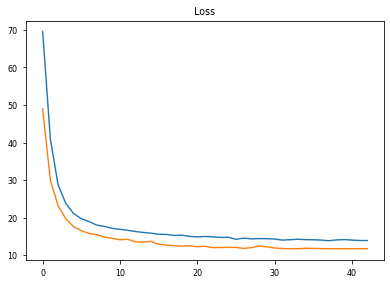

In [72]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [73]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_transformer.hdf5')

In [74]:
predict_nn_transformer = model.predict([text_test_sequences['input_ids'],text_test_sequences['attention_mask'], X_test])
print(f"TEST mape: {(mape(np.exp(y_test), predict_nn_transformer[:,0]))*100:0.2f}%")

#TEST mape: 11.68%

TEST mape: 11.68%


In [75]:
sub_predict_nn_transformer = model.predict([text_sub_sequences['input_ids'],text_sub_sequences['attention_mask'], X_sub])
sample_submission['price'] = sub_predict_nn_transformer[:, 0]
sample_submission['price'] = round_to(sample_submission['price'], 1000)
sample_submission.to_csv('nn_transformer_submission_round.csv', index=False)

#### Результат модели на Kaggle - 12.43951

В целом модель показала достаточно скромные результаты. Возможно, стоило все-таки уменьшить темп обучения (но тут возникала проблема нехватки времени и квоты на графический процессор...). Скорее всего, при существенном увеличении количества данных модель также была бы более результативной. 